In [409]:
import numpy as np
import pandas as pd
import scipy, scipy.spatial
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import speechpy
from pydub import AudioSegment
from matplotlib.patches import ConnectionPatch
%matplotlib inline

import io
from urllib.request import urlopen

In [2]:
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = None

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_26326/1168612819.py:11: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['image.interpolation'] = None


In [3]:
def onsetDetect(signal, sr, hop_length, n_fft):
    onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
    onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length, n_fft=n_fft)
    trim_frames = []
    trim_frames.append(onset_frames_back[0]-1)
    trim_frames.append(onset_frames[-1]+2)
    trim_times = librosa.frames_to_time(trim_frames, sr=sr, hop_length=hop_length, n_fft = n_fft)
    return trim_frames, trim_times

def drawOnset(signal, trim_times, sr):
    librosa.display.waveshow(signal, sr=sr)
    plt.vlines(trim_times, min(signal), max(signal), color='r', alpha=0.8)
    
def trimSound(path, filename, trim_times):
    sound = AudioSegment.from_file(path+filename, format='mp3')
    trim = sound[trim_times[0]*1000:trim_times[1]*1000]
    return trim

def trimSave(trim, path, filename):
    trim.export(path + filename, format='mp3')
    
def getMFCC(signal, n_mfcc, sr, hop_length, n_fft):
    mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
    mfccs = mfccs[1:,]
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    return comprehensive_mfccs

def showMFCC(mfcc, sr, hop_length, n_fft):
    librosa.display.specshow(mfcc,
                        x_axis="time",
                        sr = sr,
                        hop_length = hop_length,
                        n_fft = n_fft)
    plt.colorbar(format="%+2.f")
    plt.show()
    
def amplitude_envelope(signal, n_fft, hop_length):
    return np.array([max(signal[i:i+n_fft]) for i in range(0, len(signal), hop_length)])


def pad(ae, target_len):
    return np.pad(ae, (0, target_len-ae.size))

def getMFCCNorm(mfcc):
    norm = speechpy.processing.cmvn(mfcc.T, variance_normalization=True)
    return norm.T

def DTW(ref_mfcc, comp_mfcc):
    D, wp = librosa.sequence.dtw(X=ref_mfcc, Y=comp_mfcc, metric='euclidean', backtrack=True)
    wp_s = np.asarray(wp) * hop_length / sr
    return D, wp, wp_s

def plotDTW(D, wp_s):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    librosa.display.specshow(D, x_axis='time', y_axis='time',
                             cmap='gray_r', hop_length=hop_length)
    ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
    plt.title('Warping Path on Acc. Cost Matrix $D$')
    plt.colorbar()
    
def plotAlign(sig1, sig2):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(12, 8))

    # Plot x_2
    librosa.display.waveshow(sig2, sr=sr, ax=ax2)
    ax2.set(title='comparison')

    # Plot x_1
    librosa.display.waveshow(sig1, sr=sr, ax=ax1)
    ax1.set(title='reference')
    ax1.label_outer()

    n_arrows = 20
    for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
        # Create a connection patch between the aligned time points
        # in each subplot
        con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                              axesA=ax1, axesB=ax2,
                              coordsA='data', coordsB='data',
                              color='r', linestyle='--',
                              alpha=0.5)
        ax2.add_artist(con)
        
def getDiff(ref_mfcc, comp_mfcc, wp):
    x = np.linspace(0, ref_mfcc.shape[1]-1, ref_mfcc.shape[1])
    re_wp = wp[::-1]
    y = [0] * ref_mfcc.shape[1]
    sig1 = 0
    for a, b in re_wp:
        val = max(0, (sum(np.abs(ref_mfcc[:,a]))-sum(np.abs(comp_mfcc[:,b])))/sum(np.abs(ref_mfcc[:,a])))
        if sig1 == a:
            y[a] = min(y[a],val)
        else:
            y[a] = min(1, val)
            sig1 = a
    return x, y, re_wp

def plotAll(x,y,ref_ae,comp_ae):
    if comp_ae.size < x.size:
        comp_ae = pad(comp_ae, x.size)
    plt.figure(figsize=(13,5))
    plt.plot(x,y, label="MFCC_Diff", color="r", linestyle='--')
    plt.plot(x,ref_ae, label="ref", color = 'darkblue', )
    plt.plot(x,comp_ae, label="comp", color = 'skyblue',)
    plt.xlabel("frames")
    plt.legend()

In [4]:
t1 = './data/naver_w.mp3'
t2 = './data/oxford_w.mp3'

y_t1, sr = librosa.load(t1)
y_t2, _ = librosa.load(t2)

hop_length = int(0.01 * sr)
n_fft = int(0.025 * sr)
print(hop_length, n_fft)

y_t1 = librosa.effects.preemphasis(y_t1)
y_t2 = librosa.effects.preemphasis(y_t2)

y_t1_trim, _ = librosa.effects.trim(y_t1, top_db = 25)
y_t2_trim, _ = librosa.effects.trim(y_t2, top_db = 25)

t1_mfcc = getMFCC(y_t1_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
t2_mfcc = getMFCC(y_t2_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)

t1_mfcc_norm = getMFCCNorm(t1_mfcc)
t2_mfcc_norm = getMFCCNorm(t2_mfcc)

t1_ae = amplitude_envelope(y_t1_trim, n_fft, hop_length)
t2_ae = amplitude_envelope(y_t2_trim, n_fft, hop_length)

D, wp, wp_s = DTW(t1_mfcc_norm, t2_mfcc_norm)
plotDTW(D, wp_s)
plotAlign(y_t1_trim, y_t2_trim)

x, y, re_wp = getDiff(t1_mfcc_norm, t2_mfcc_norm, wp)
plotAll(x,y,t1_ae,t2_ae)

/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: './data/naver_w.mp3'

In [522]:
import sre_parse

def sound_diff(path, ref, target, sr):

    def onsetDetect(signal, sr, hop_length, n_fft):
        onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
        onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)
        trim_frames = []
        trim_frames.append(onset_frames_back[0]-1)
        trim_frames.append(onset_frames[-1]+2)
        trim_times = librosa.frames_to_time(trim_frames, sr=sr, hop_length=hop_length, n_fft = n_fft)
        return trim_frames, trim_times
        
    def getMFCC(signal, n_mfcc, sr, hop_length, n_fft):
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
        mfccs = mfccs[1:,]
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        return comprehensive_mfccs
        
    def amplitude_envelope(signal, n_fft, hop_length):
        return np.array([max(signal[i:i+n_fft]) for i in range(0, len(signal), hop_length)])

    def getMFCCNorm(mfcc):
        norm = speechpy.processing.cmvn(mfcc.T, variance_normalization=True)
        return norm.T

    def DTW(ref_mfcc, comp_mfcc):
        D, wp = librosa.sequence.dtw(X=ref_mfcc, Y=comp_mfcc, metric='euclidean', backtrack=True)
        wp_s = np.asarray(wp) * hop_length / sr
        return D, wp, wp_s

    def plotDTW(D, wp_s):
        fig = plt.figure(figsize=(13, 10))
        ax = fig.add_subplot(111)
        librosa.display.specshow(D, x_axis='time', y_axis='time',
                                cmap='gray_r', hop_length=hop_length)
        ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
        plt.rcParams['axes.grid']=False
        plt.colorbar()
        plt.title('Warping Path on Acc. Cost Matrix $D$')
    
    def getDiff(ref_mfcc, comp_mfcc, wp, sr, hop_length, n_fft, ref_ae, comp_ae):
        x = np.linspace(0, ref_mfcc.shape[1]-1, ref_mfcc.shape[1])
        x_time = librosa.frames_to_time(x, sr=sr, hop_length=hop_length, n_fft = n_fft)
        re_wp = wp[::-1]
        y = [0] * ref_mfcc.shape[1]
        sig1 = 0
        for a, b in re_wp:
            tmp = sum(np.abs(ref_mfcc[:,a]))
            val = max(0,abs(sum(np.abs(ref_mfcc[:,a])) - sum(np.abs(comp_mfcc[:,b])))/(tmp if int(tmp) !=0 else 1))
            if sig1 == a:
                y[a] = min(y[a],val)
            else:
                y[a] = min(1, val)
                sig1 = a

        for idx in range(len(y)):
            if ref_ae[idx] == comp_ae[idx]:
                y[idx] = 0

        return x_time, y, re_wp
    
    def getDiff_v2(ref_mfcc, comp_mfcc, wp, sr, hop_length, n_fft):
        x = np.linspace(0, ref_mfcc.shape[1]-1, ref_mfcc.shape[1])
        x_time = librosa.frames_to_time(x, sr=sr, hop_length=hop_length, n_fft = n_fft)
        re_wp = wp[::-1]

        y = [0] * int(x.shape[0])
        tmp = [0] * int(x.shape[0])
        for ref_fr, comp_fr in re_wp:
            tmp[ref_fr] = D[ref_fr,comp_fr]
            y[ref_fr] = tmp[ref_fr] - tmp[ref_fr-1]
        
        y = np.array(y)
        y_norm = y/15
        y_norm[y_norm > 1] = 1
        return x_time, y_norm, re_wp

    def plotAlign(ref, comp, x, y, ref_ae, comp_ae):
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(13, 15))
        
        # Plot x_2
        librosa.display.waveshow(comp, sr=sr, ax=ax2)
        ax2.set(title='comparison waveplot')
        ax2.grid(True, axis='both')

        # Plot x_1
        librosa.display.waveshow(ref, sr=sr, ax=ax1)
        ax1.set(title='reference waveplot')
        ax1.label_outer()
        ax1.grid(True, axis='both')
        n_arrows = 20
        for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
            con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                                axesA=ax1, axesB=ax2,
                                coordsA='data', coordsB='data',
                                color='r', linestyle='--',
                                alpha=0.5)
            ax2.add_artist(con)
        
        ax3.set(title='ref v comparison')
        ax3.grid(True, axis='both')
        ax3.plot(x,y, label="MFCC_Diff", color="r", linestyle='--')
        ax3.plot(x,ref_ae, label="ref", color = 'darkblue')
        ax3.plot(x,comp_ae, label="comp", color = 'skyblue')
        ax3.set_xlabel("Time")
        ax3.set_ylim(ymin=0, ymax=1)
        ax3.legend()

    y_ref, sr = librosa.load(path+ref, mono=True, sr=sr)
    y_comp, _ = librosa.load(path+target, mono=True, sr=sr)

    hop_length = int(round(0.01 * sr,0))
    n_fft = int(round(0.025 * sr,0))

    y_ref[abs(y_ref)<0.0009] = 0
    y_comp[abs(y_comp)<0.0009] = 0

    y_ref = librosa.effects.preemphasis(y_ref)
    y_comp = librosa.effects.preemphasis(y_comp)

    y_ref_trim, _ = librosa.effects.trim(y_ref, top_db = 25)
    y_comp_trim, _ = librosa.effects.trim(y_comp, top_db = 25)

    # y_ref_trim = y_ref
    # y_comp_trim = y_comp

    ref_mfcc = getMFCC(y_ref_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
    comp_mfcc = getMFCC(y_comp_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)

    ref_mfcc_norm = getMFCCNorm(ref_mfcc)
    comp_mfcc_norm = getMFCCNorm(comp_mfcc)

    # ref_mfcc_norm = ref_mfcc
    # comp_mfcc_norm = comp_mfcc

    if comp_mfcc_norm.shape[1] > ref_mfcc_norm.shape[1]:
        
        c = scipy.signal.correlate(y_comp_trim, y_ref_trim, mode="valid", method="fft")
        peak = np.argmax(c)

        pad_num = min(int(round(peak,0)), y_comp_trim.shape[0])
        # y_ref_trim = np.pad(y_ref_trim, (pad_num,0), 'linear_ramp', end_values=(0,0))
        # y_ref_trim = np.pad(y_ref_trim, (0,int(y_comp_trim.shape[0]) - int(y_ref_trim.shape[0])), 'linear_ramp', end_values=(0,0))

        zeros = np.zeros(pad_num,)
        y_ref_trim = np.concatenate((zeros, y_ref_trim), axis=0)
        zeros = np.zeros((int(y_comp_trim.shape[0]) - int(y_ref_trim.shape[0]),))
        y_ref_trim = np.concatenate((y_ref_trim, zeros), axis=0)

        pad_hop = min(int(round(peak/hop_length,0)), comp_mfcc_norm.shape[1])
        # ref_mfcc_norm = np.pad(ref_mfcc_norm, ((0,0),(pad_hop,0)), 'linear_ramp', end_values=(0,0))
        # ref_mfcc_norm = np.pad(ref_mfcc_norm, ((0,0),(int(comp_mfcc_norm.shape[1]) - int(ref_mfcc_norm.shape[1]),0)), 'linear_ramp', end_values=(0,0))

        zeros = np.zeros((int(ref_mfcc_norm.shape[0]), pad_hop))
        ref_mfcc_norm = np.concatenate((zeros, ref_mfcc_norm), axis=1)

        zeros = np.zeros((int(ref_mfcc_norm.shape[0]), int(comp_mfcc_norm.shape[1]) - int(ref_mfcc_norm.shape[1])))
        ref_mfcc_norm = np.concatenate((ref_mfcc_norm, zeros), axis=1)
    
    elif comp_mfcc_norm.shape[1] < ref_mfcc_norm.shape[1]:

        c = scipy.signal.correlate(y_ref_trim, y_comp_trim, mode="valid", method="fft")
        peak = np.argmax(c)
        
        pad_num = min(int(round(peak,0)), y_ref_trim.shape[0])
        # y_comp_trim = np.pad(y_comp_trim, (pad_num,0), 'linear_ramp', end_values=(0,0))
        # y_comp_trim = np.pad(y_comp_trim, (0,int(y_ref_trim.shape[0]) - int(y_comp_trim.shape[0])), 'linear_ramp', end_values=(0,0))

        zeros = np.zeros(pad_num,)
        y_comp_trim = np.concatenate((zeros, y_comp_trim), axis=0)
        zeros = np.zeros((int(y_ref_trim.shape[0]) - int(y_comp_trim.shape[0]),))
        y_comp_trim = np.concatenate((y_comp_trim, zeros), axis=0)

        pad_hop = min(int(round(peak/hop_length,0)), ref_mfcc_norm.shape[1])
        # comp_mfcc_norm = np.pad(comp_mfcc_norm, ((0,0),(pad_hop,0)), 'linear_ramp', end_values=(0,0))
        # comp_mfcc_norm = np.pad(comp_mfcc_norm, ((0,0),(int(ref_mfcc_norm.shape[1]) - int(comp_mfcc_norm.shape[1]),0)), 'linear_ramp', end_values=(0,0))

        zeros = np.zeros((int(comp_mfcc_norm.shape[0]), pad_hop))
        comp_mfcc_norm = np.concatenate((zeros, comp_mfcc_norm), axis=1)
        zeros = np.zeros((int(comp_mfcc_norm.shape[0]), int(ref_mfcc_norm.shape[1]) - int(comp_mfcc_norm.shape[1])))
        comp_mfcc_norm = np.concatenate((comp_mfcc_norm, zeros), axis=1)

    D, wp, wp_s = DTW(ref_mfcc_norm, comp_mfcc_norm)
    ref_ae = amplitude_envelope(y_ref_trim, n_fft, hop_length)
    comp_ae = amplitude_envelope(y_comp_trim, n_fft, hop_length)
    x, y, re_wp = getDiff(ref_mfcc_norm, comp_mfcc_norm, wp, sr, hop_length, n_fft, ref_ae, comp_ae)
    print(len(y), x.shape, ref_mfcc_norm.shape, comp_mfcc_norm.shape, y_ref_trim.shape, y_comp_trim.shape, ref_ae.shape, comp_ae.shape)
    plotDTW(D, wp_s)
    plotAlign(y_ref_trim, y_comp_trim, x, y, ref_ae, comp_ae)

    return x, y, re_wp, ref_mfcc_norm, comp_mfcc_norm, y_ref_trim, y_comp_trim, ref_mfcc, comp_mfcc, D, wp, wp_s, ref_ae, comp_ae

In [520]:
path = '../english_recordings/test/'
ref = 'english1_stella.mp3'
comp = 'korean1_stella.mp3'
sr = 22050

/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/Users/hsada17/opt/anaconda3/envs/ds_study/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


54 (54,) (36, 54) (36, 54) (11776,) (11776,) (54,) (54,)


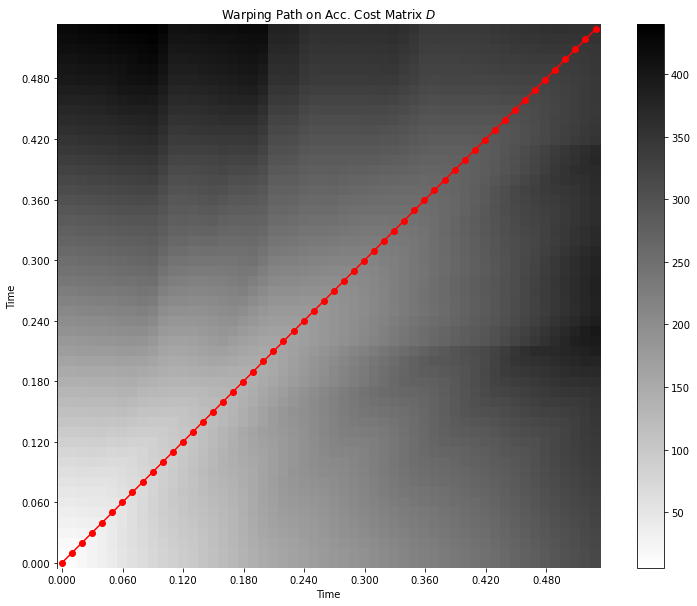

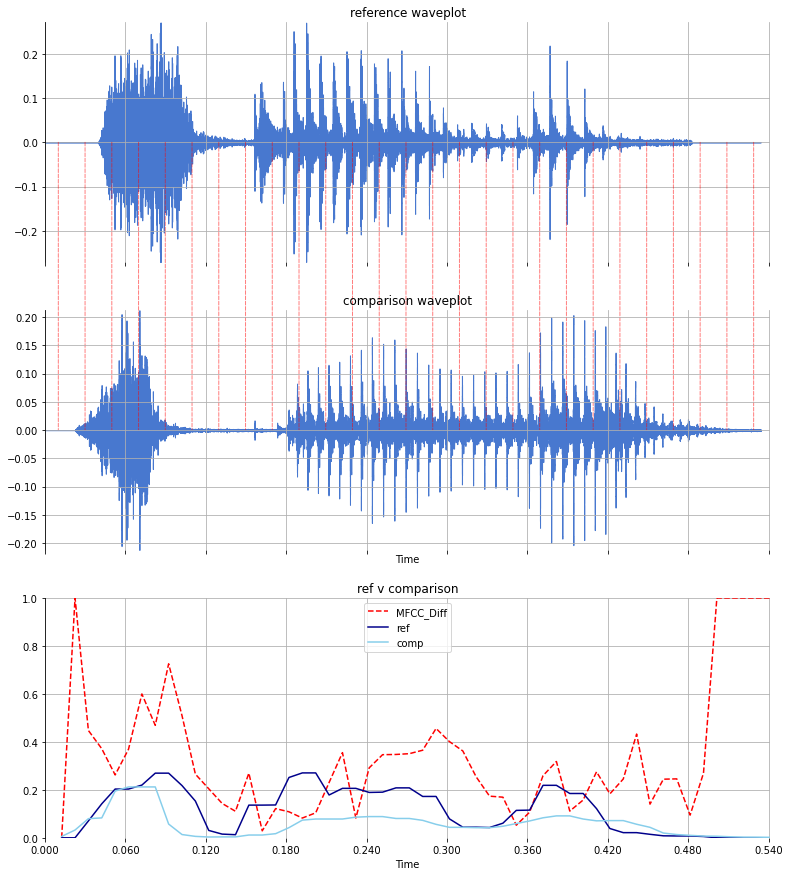

In [523]:
x, y, re_wp, ref_mfcc_norm, comp_mfcc_norm, y_ref_trim, y_comp_trim, ref_mfcc, comp_mfcc, D, wp, wp_s,ref_ae, comp_ae = sound_diff(path, ref, comp, sr)

In [431]:
D[1,1], D[2,2], D[3,3]

(11.49449659159381, 19.33346581571286, 27.036808132232945)

In [408]:
test_cost = [0]* 84
tmp = [0] * 84
for x, y in re_wp:
    tmp[x] = D[x,y]
    test_cost[x] = tmp[x] - tmp[x-1]

In [402]:
import pandas as pd
xx = np.array(test_cost)
xx_df = pd.DataFrame(xx)

In [406]:
xx = np.array(test_cost)
xx_norm = xx/20

In [407]:
xx_norm

array([0.26789246, 0.26789246, 0.33112311, 0.29320527, 0.42846282,
       0.32016082, 0.38850702, 0.39663794, 0.37606752, 0.32602166,
       0.31131464, 0.68495317, 0.40272729, 0.3623865 , 0.42104031,
       0.39735775, 0.39458903, 0.47933727, 0.44760556, 0.42825711,
       0.39119224, 0.4264709 , 0.44594632, 0.44196878, 0.43070127,
       0.41848648, 0.39758083, 0.41331039, 0.38943385, 0.36130413,
       0.36347404, 0.3479312 , 0.28470135, 0.31801112, 0.35998101,
       0.36285348, 0.34369608, 0.36851499, 0.39204121, 0.38418738,
       0.31234059, 0.31147234, 0.27970533, 0.32588598, 0.31071227,
       0.33763451, 0.34959939, 0.34873513, 0.34077371, 0.34309953,
       0.33453388, 0.33134631, 0.32179425, 0.31182886, 0.28317236,
       0.23750311, 0.2675489 , 0.27789752, 0.24610593, 0.28846533,
       0.26433094, 0.27539865, 0.22581918, 0.25865478, 0.30573421,
       0.34338377, 0.31396412, 0.27959339, 0.28901448, 0.3198948 ,
       0.27013065, 0.25931675, 0.25298824, 0.30857302, 0.23021

In [ ]:
from bs4 import BeautifulSoup
import requests
import urllib.request
import re
import pathlib
import os

cambridge = 'https://dictionary.cambridge.org'
dic = 'https://dictionary.cambridge.org/dictionary/english-korean/'
word = 'station'

r = requests.get(dic+word, headers={'User-Agent':'Mozilla/5.0'})
url = r.content
soup = BeautifulSoup(url, 'html.parser')

camb_sound_raw = soup.find_all('source')[2]
camb_sound_geturl = re.search('"(.+?)"', str(camb_sound_raw)).group(1)
camb_sound_ref_url = cambridge+camb_sound_geturl

file = requests.get(camb_sound_ref_url, headers=headers, allow_redirects=True)
path = os.getcwd()+'/data/'
if os.path.exists(path+word) == True:
    pass
else:
    mp3_path = os.makedirs(path+word)
mp3_path = path+word+'/ref.mp3'
open(mp3_path, 'wb').write(file.content)

SSLError: HTTPSConnectionPool(host='dictionary.cambridge.org', port=443): Max retries exceeded with url: /dictionary/english-korean/station (Caused by SSLError("Can't connect to HTTPS URL because the SSL module is not available."))

In [8]:
ref_sound = mp3_path
sound_diff(ref_sound, t2)

NameError: name 'mp3_path' is not defined